In [149]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from control.matlab import *
import slycot
import os
from scipy import signal, io
from scipy.linalg import fractional_matrix_power

# Python control toolbox available at https://python-control.readthedocs.io/

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})


In [150]:
testSys_mat = io.loadmat(os.path.join('..','DATA','testSys_ABCD.mat'))
A = testSys_mat['A']
B = testSys_mat['B']
C = testSys_mat['C']
D = testSys_mat['D']

sysFull = ss(A,B,C,D,1)
r = 10 # Reduced model order

In [152]:
## Plot Hankel Singular Values
# n_stable = np.count_nonzero(np.logical_and(np.linalg.eigvals(sysFull.A).real >= 0, np.linalg.eigvals(sysFull.A).real <= 1))
# sysFull_stable = balred(sysFull,n_stable,method='truncate',alpha=np.array([0,1])) # This is necessary to remove unstable eigenvalues
# hsvs = hsvd(sysFull_stable) # Hankel singular values
hsvs = hsvd(sysFull)

ValueError: Oops, the system is unstable!

In [63]:
# Balanced truncation
sysBT = balred(sysFull,r)

C:\ProgramData\Anaconda3\lib\site-packages\slycot\analysis.py:1036: UserWarning: with ordsel = 'F', the selected order nr is less                than the order of the alpha-unstable part of the                given system. In this case nr is set equal to the                order of the alpha-unstable part.
  order of the alpha-unstable part.")


In [143]:
# Compute BPOD

yFull = np.zeros((r*5+2,p,q))
xFull = np.zeros((r*5+2,n,q))
yAdj = np.zeros_like(yFull)
xAdj = np.zeros_like(xFull)

sysAdj = ss(sysFull.A.T,sysFull.C.T,sysFull.B.T,sysFull.D.T,1)

for qi in range(q):
    yFull[:,:,qi],_,xFull[:,:,qi] = impulse(sysFull,T=np.arange(0,(r*5+2),1),input=qi,return_x=True)
    yAdj[:,:,qi],_,xAdj[:,:,qi] = impulse(sysAdj,T=np.arange(0,(r*5+2),1),input=qi,return_x=True)


# Not the fastest way to compute, but illustrative
# Both xAdj and xFull are size (length of t) * (number of states) * (number of inputs)


HankelOC = np.zeros((q*(r*5+1),q*(r*5+1)))
for i in range(xAdj.shape[0]-1): # start at 1 to avoid the D matrix
    for j in range(xFull.shape[0]-1):
        Ystar = np.swapaxes(np.squeeze(xAdj[i+1,:,:]),0,1);        
        MarkovParameter = Ystar@np.squeeze(xFull[j+1,:,:]);
        HankelOC[np.ix_(range(q*i,q*(i+1)),range(q*j,q*(j+1)))] = MarkovParameter

U,Sig,VT = np.linalg.svd(HankelOC)
Sig = np.diag(Sig)
V = VT.T

Xdata = np.zeros((n,q*(xFull.shape[0]-1)))
Ydata = np.zeros((n,q*(xFull.shape[0]-1)))
for i in range(xFull.shape[0]-1):
    Xdata[:,range(q*i,q*(i+1))] = xFull[i+1,:,:]
    Ydata[:,range(q*i,q*(i+1))] = xAdj[i+1,:,:]
    
Phi = Xdata @ V @ fractional_matrix_power(Sig,-1/2)
Psi = Ydata @ U @ fractional_matrix_power(Sig,-1/2)

Ar = Psi[:,:r].T @ sysFull.A @ Phi[:,:r]
Br = Psi[:,:r].T @ sysFull.B
Cr = sysFull.C @ Phi[:,:r]
Dr = sysFull.D

sysBPOD = ss(Ar,Br,Cr,Dr,1)

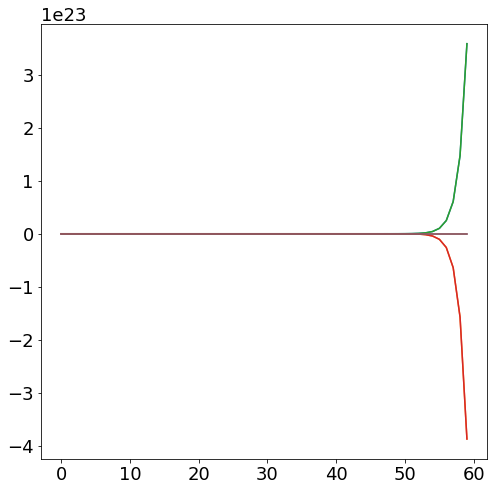

In [148]:
## Plot impulse responses for all methods
yout_full,tout_full = impulse(sysFull,np.arange(0,60,1))
yout_BT,tout_BT = impulse(sysBT,np.arange(0,60,1))
yout_BPOD,tout_BPOD = impulse(sysBPOD,np.arange(0,60,1))

plt.plot(tout_full,yout_full,label='Full model, n=100')
plt.plot(tout_BT,yout_BT,label='Balanced truncation, r=10')
plt.plot(tout_BPOD,yout_BPOD,label='Balanced POD, r=10')
plt.show()